<a href="https://colab.research.google.com/github/PhD-Gabriel-Caballero/ESA-summer-school-2023-Croatia/blob/main/ARTMO_BV_GPR_model_GEE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARTMO-based LAI retrieval modelling using Gaussian process regression in Google Earth Engine (GEE)

---

This Jupyter notebook contains all the necessary information for retrieving the Leaf Area Index (LAI) using GPR in the Google Earth (GEE) cloud computing platform. This material has been created exclusively for the 2023 European Space Agency (ESA) summer school.

---
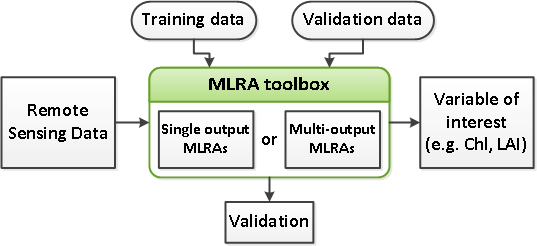

---

Credits and references

1.   Caballero G, Pezzola A, Winschel C, Casella A, Sanchez Angonova P, Rivera-Caicedo JP, Berger K, Verrelst J, Delegido J. Seasonal Mapping of Irrigated Winter Wheat Traits in Argentina with a Hybrid Retrieval Workflow Using Sentinel-2 Imagery. Remote Sensing. 2022; 14(18):4531. https://doi.org/10.3390/rs14184531

2. Casella, A.; Orden, L.; Pezzola, N.A.; Bellaccomo, C.; Winschel, C.I.; Caballero, G.R.; Delegido, J.; Gracia, L.M.N.; Verrelst, J. Analysis of Biophysical Variables in an Onion Crop (Allium cepa L.) with Nitrogen Fertilization by Sentinel-2 Observations. Agronomy 2022, 12, 1884. https://doi.org/10.3390/agronomy12081884

**Install the required libraries**

In [ ]:
!pip install geemap
!pip install earthengine-api
!pip install PyCRS

**Import ee library**

In [70]:
import geemap, ee, os, sys, pycrs, datetime
import geemap.colormaps as cm

from ipyleaflet import *
from ipywidgets import Label
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.dates as mdates
import matplotlib.ticker as ticker

Mount Google Drive

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Clone the GitHub repository**

In [32]:
!rm -r ESA-summer-school-2023-Croatia # delete the complete repository folder
!git clone https://github.com/PhD-Gabriel-Caballero/ESA-summer-school-2023-Croatia # clone repository folder
sys.path.insert(0,'/content/ESA-summer-school-2023-Croatia')

Cloning into 'ESA-summer-school-2023-Croatia'...
remote: Enumerating objects: 303, done.
remote: Counting objects: 100% (250/250), done.
remote: Compressing objects: 100% (168/168), done.
remote: Total 303 (delta 193), reused 116 (delta 80), pack-reused 53
Receiving objects: 100% (303/303), 37.45 MiB | 10.53 MiB/s, done.
Resolving deltas: 100% (204/204), done.


**Authenticate and initialize ee**

In [ ]:
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

**Select the Area of Interest**

In [71]:
# Set map display properties.
Map = geemap.Map(toolbar_ctrl=True, layer_ctrl=True)
Map.default_style = {'cursor': 'crosshair'}
Map.add_basemap('SATELLITE')

# Center the map in the desired country
country = 'Argentina'
country_bounds = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017").filterMetadata('country_na', 'equals', country);
Map.centerObject(country_bounds,12)
Map

Map(center=[-34.687845828472675, -64.74963675588427], controls=(WidgetControl(options=['position', 'transparen…

**Show the Region Of Interest (ROI) in the interactive map**

In [72]:
# Please provide here the information on the experimental station and the boundaries of your crop essay.
wheat_roi = geemap.shp_to_ee('/content/ESA-summer-school-2023-Croatia/Vectors/Wheat trial sketch 2020/wheat trial sketch 2020.shp')
EEHA_roi = geemap.shp_to_ee('/content/ESA-summer-school-2023-Croatia/Vectors/EEHA boundaries/INTA EEHA subdivision 2020.shp')
wheat_insitu_points =  geemap.shp_to_ee('/content/ESA-summer-school-2023-Croatia/Vectors/Wheat sampling points 2020/wheat_sampling_points_2020.shp')
wheat_insitu_points_insitu_data_2020 = geemap.shp_to_ee('/content/ESA-summer-school-2023-Croatia/Vectors/Wheat sampling points 2020/wheat_sampling_points_insitu_data_2020.shp')

Map.addLayer(wheat_roi, {},'Wheat roi 2020',True, opacity = 0.3)
Map.addLayer(wheat_insitu_points, {},'Wheat insitu points 2020',True)
Map.addLayer(EEHA_roi, {},'Study area',True, opacity = 0.5)

**Retrieve the ROI from the map**

In [14]:
feature = Map.draw_last_feature
roi = feature.geometry()

**Import models**

In [35]:
!cp /content/drive/MyDrive/BOAModelsV2.py .
import BOAModelsV2

**Set variable model to process**

In [36]:
#['LAIGreen', 'Cab', 'Cm', 'Cw', 'FVC', 'LAI', 'laiCab', 'laiCm', 'laiCw', 'LAIBrown']
currentVegIndex = 'LAIGreen'
currentModel = BOAModelsV2.models[currentVegIndex]

**Functions**

In [37]:
# Masking function for water and cloud
def maskS2cloud_and_water(image):
  not_water = image.select('SCL').neq(6);
  not_cloud_low = image.select('SCL').neq(7);
  not_cloud_medium = image.select('SCL').neq(8);
  not_cloud_high = image.select('SCL').neq(9);
  not_cirrus = image.select('SCL').neq(10);

  qa = image.select('QA60');
  cloudBitMask = 1 << 10;
  cirrusBitMask = 1 << 11;
  mask = (qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0)).And(not_water).And(not_cloud_low)
          .And(not_cloud_medium).And(not_cloud_high).And(not_cirrus))
  return image.updateMask(mask).divide(currentModel['scaleFactor']).copyProperties(qa).set('system:time_start', qa.get('system:time_start'))

# Auxiliar function for mapping : (1..n) -> (B1..Bn)
def band_names(element):
  bandName = ee.String('B').cat(ee.Number(element).int().format())
  return bandName

def addDoy(image):
  doy = image.date().getRelative('day', 'year')
  doyBand = ee.Image.constant(doy).uint16().rename('doy')
  return image.addBands(doyBand)

# Veg index GPR for mean prediction
def veg_index_GPR(image_orig):

  # Create List of Bands of Dimension n (Xtrain[n,n])
  XTrain_dim = currentModel['X_train'].length().get([0]).getInfo();

  band_sequence   = (ee.List.sequence(1, XTrain_dim)
                    .map(band_names));

  # Create a list of band names for flattening operation
  im_norm_ell2D_hypell = image_orig.subtract(ee.Image(currentModel['mx'])).divide(ee.Image(currentModel['sx'])).multiply(ee.Image(currentModel['hyp_ell'])).toArray().toArray(1);

  im_norm_ell2D = image_orig.subtract(ee.Image(currentModel['mx'])).divide(ee.Image(currentModel['sx'])).toArray().toArray(1);

  PtTPt  = im_norm_ell2D_hypell.matrixTranspose().matrixMultiply(im_norm_ell2D).arrayProject([0]).multiply(-0.5);

  PtTDX  = ee.Image(currentModel['X_train']).matrixMultiply(im_norm_ell2D_hypell).arrayProject([0]).arrayFlatten([band_sequence]);

  arg1   = PtTPt.exp().multiply(currentModel['hyp_sig']);

  k_star = PtTDX.subtract(ee.Image(currentModel['XDX_pre_calc']).multiply(0.5)).exp().toArray();

  mean_pred = k_star.arrayDotProduct(ee.Image(currentModel['alpha_coefficients']).toArray()).multiply(arg1);

  mean_pred = mean_pred.toArray(1).arrayProject([0]).arrayFlatten([[currentModel['veg_index']]]);

  mean_pred = mean_pred.add(currentModel['mean_model']);

  # Mask values equal or less than 0
  mean_pred = mean_pred.updateMask(mean_pred.gt(0))

  image_orig = image_orig.addBands(mean_pred)

  return image_orig.select(currentModel['veg_index'])

def mask_gt(image):
  veg_index_mask = image.select(currentModel['veg_index']).gt(0).rename('veg_index_mask')
  return image.addBands(veg_index_mask).select('veg_index_mask')

def addVariables(image):
  date = ee.Date(image.get("system:time_start"))
  years = date.difference(ee.Date('1970-01-01'),'days')
  return image.addBands(ee.Image(years).rename('t').float())

In [42]:
def extract_ts(roi, col, band):
    """ Constructs a dataframe with the time series for the ROI with the image
        collection.

        Parameters
        ----------
        roi : ee.Geometry, Region of interest

        col : ee.ImageCollection

        band : string, Name of the band to retrieve

        Returns
        ------
        A pandas dataframe

    """

    # Auxiliar function to replace the null values with custom value(-9999)
    # so we do not lose the masked values.
    def set_NAN(key,val):
        return ee.List([val, -9999]).reduce(ee.Reducer.firstNonNull())

    # Retrieve the mean value of the band in the roi and the date of the image
    def get_ts(image):
        stat = image.select([band]).reduceRegion(
            reducer = ee.Reducer.mean(),
            geometry= roi,
            scale= 20,
            bestEffort= True
        )
        stat = stat.map(set_NAN)
        return ee.Feature(roi, stat).set({'millis': image.date().millis()})

    # List of features containing the reduced value and the date
    ts = col.map(get_ts)

    # Lists of values and dates
    y = ts.aggregate_array(band).getInfo()
    dates_ms = ts.aggregate_array('millis').getInfo() # Date in ms
    x = [datetime.fromtimestamp(d//1000.0) for d in dates_ms] # Formatted date

    # Dictionary that will feed the pandas dataframe
    dict = {'date': x, band: y}
    # Contruct the df and replace the custom NaN values(-9999) with np.nan
    df = pd.DataFrame(dict).replace(-9999, np.nan)
    return df

**Dates of interest**

In [57]:
start_date = '2019-01-01'
end_date = '2023-09-13'

**Create the initial image collection with the spectral bands**

In [58]:
S2collection_ini = ee.ImageCollection('COPERNICUS/S2_SR')\
                   .filterBounds(roi)\
                   .filterDate(start_date,end_date)\
                   .map(maskS2cloud_and_water)\
                   .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12'])

**Create the predicted mean image collection**

In [59]:
targetCollection =  S2collection_ini.map(veg_index_GPR).select(currentModel['veg_index'])

**Extract the time series and plot it**

In [60]:
df_S2 = extract_ts(roi, targetCollection, currentModel['veg_index'])
df_S2

,date,LAI_GREEN
0,2019-01-02 14:13:33,5.777838
1,2019-01-07 14:13:30,4.370315
2,2019-01-12 14:13:34,NaN
3,2019-01-17 14:13:31,4.074588
4,2019-01-22 14:13:35,4.150137
...,...,...
336,2023-08-24 14:13:41,1.184245
337,2023-08-29 14:13:40,1.333721
338,2023-09-03 14:13:37,NaN
339,2023-09-03 14:13:44,NaN


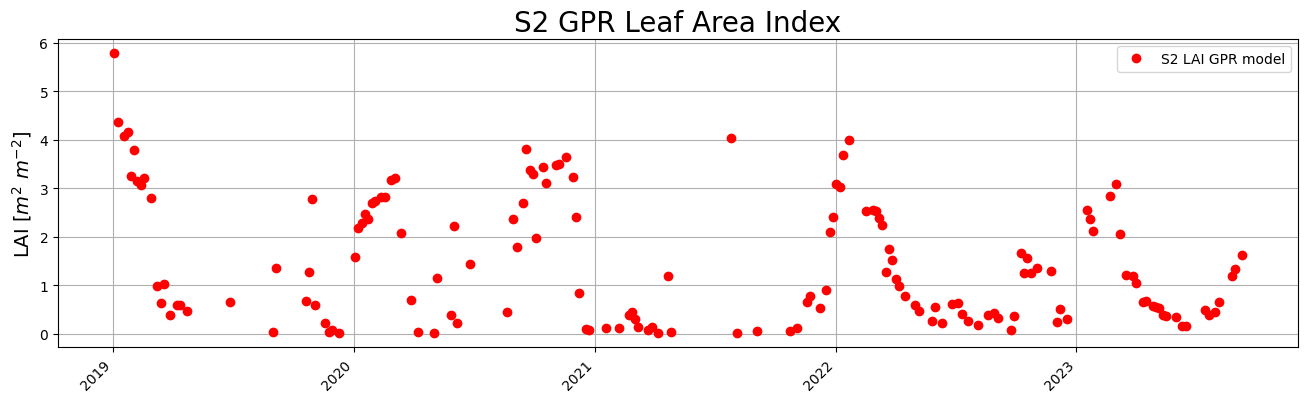

In [61]:
# Sentinel 2 LAI GPR model time series plotting
plt.figure(figsize= (16,4))

plt.plot(df_S2['date'], df_S2[currentModel['veg_index']],'ro',label='S2 LAI GPR model')
plt.title('S2 GPR Leaf Area Index',fontsize='20')
plt.legend()
plt.grid(1)
plt.ylabel('LAI [$m^2$ $m^{-2}$]',fontsize='14')
plt.grid(1)
plt.xticks(rotation=45, ha='right')
plt.show()

**Guide on establishing colour schemes for plotting interactive maps**

In [62]:
# Thematic colour palette definition for LAI mapping

palette = [
    'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
    '74A901', '66A000', '529400', '3E8601', '207401', '056201',
    '004C00', '023B01', '012E01', '011D01', '011301']

LAI_palette_1  = {"min":0.5, "max":3.5, 'palette':palette}

In [116]:
# Map display parameters definition (RGB S2 image)
# Define visualization parameters for image
vizParams = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 500,
  'max': 4000,
}
#cm.list_colormaps()

Define an interactive map

In [117]:
Map_S2 = geemap.Map(toolbar_ctrl=True, layer_ctrl=True)
Map_S2.centerObject(roi, 14)
Map_S2.set_plot_options(add_marker_cluster=True)
Map_S2

Map(center=[-39.400619500266124, -62.63928250022521], controls=(WidgetControl(options=['position', 'transparen…

LAI map plotting

In [118]:
# S2-based leaf area index map display

image_number = 337 # select the ordinal number of the image you want to be displayed

# Converting the S2 image collection to an image list for RGB scene display
S2collection_list = S2collection_ini.toList(S2collection_ini.size());
S2image = ee.Image(S2collection_list.get(image_number));

# S2 RGB image display

Map_S2.addLayer(S2image,vizParams,'S2 RGB composite',True)

# Single variable display

S2_PI_LAI_image = targetCollection.toBands().clip(EEHA_roi)
Map_S2.addLayer(S2_PI_LAI_image.select(image_number),LAI_palette_1, 'S2 PI LAI')

# On-screen display of color bars

Map_S2.add_colorbar(LAI_palette_1, label="LAI ($m^2$ $m^{-2}$)", orientation="horizontal", layer_name="LAI color bar")

# On-screen display of vector shapefile
Map_S2.addLayer(EEHA_roi, {},'Study area',True, opacity = 0.3)